In [1]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from imgaug import augmenters as iaa
import random
import math

from keras.metrics import *
from keras.callbacks import EarlyStopping, ModelCheckpoint

from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from segmentation_models.backbones import get_preprocessing

from unet_project.image_utils import ImageUtils

Using TensorFlow backend.
/home/ajuska/Dokumenty/Skola/diplomka/diplomka/lib/python3.5/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [2]:
train_frame_path = '/home/ajuska/Dokumenty/Skola/diplomka/disk/train_imgs/train'
train_mask_path = '/home/ajuska/Dokumenty/Skola/diplomka/disk/train_masks/train'

val_frame_path = '/home/ajuska/Dokumenty/Skola/diplomka/disk/val_imgs/val'
val_mask_path = '/home/ajuska/Dokumenty/Skola/diplomka/disk/val_masks/val'

img_height = 512
img_width = 512
img_channels = 3

no_train_imgs = len(os.listdir('/home/ajuska/Dokumenty/Skola/diplomka/disk/train_imgs/train'))
no_val_imgs = len(os.listdir('/home/ajuska/Dokumenty/Skola/diplomka/disk/val_imgs/val/'))

epochs = 50
batch_size = 2

backbone = 'resnet34'

preprocess_input = get_preprocessing(backbone)
image_ut = ImageUtils(train_frame_path, train_mask_path, img_height, img_width, architecture='unet')

In [3]:
def augmentation():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Crop(percent=(0, 0.1)), 
        iaa.GaussianBlur((0, 1.0)), 
        iaa.ContrastNormalization((0.9, 1.1)),
        iaa.Multiply((0.9, 1.1), per_channel=0.1),
        sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1))),
        iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-0.01, 0.01),
            shear=(-8, 8)
        )
    ], random_order=True) 
    return seq

seq = augmentation()

In [4]:
def data_gen(path_to_imgs, path_to_masks, batch_size):
    names = os.listdir(path_to_imgs)
    random.shuffle(names)
    while 1:
        img = []
        mask = []       
        all_aug_im = []
        all_aug_ma = []
        
        for idx in range(int(batch_size/2)):
#             train_img = image_ut.normalized(cv2.imread(path_to_imgs+'/'+names[idx]))#/255
            train_img = cv2.imread(path_to_imgs+'/'+names[idx])
            train_img =  cv2.resize(train_img, (img_height, img_width))
            img.append(train_img)
            
            train_mask = cv2.imread(path_to_masks+'/'+names[idx], cv2.IMREAD_GRAYSCALE)#/255
            train_mask = cv2.resize(train_mask, (img_height, img_width))
            train_mask = train_mask.reshape(img_height, img_width, 1)
            mask.append(train_mask)
        
        for i in range(2):
            seq = augmentation()
            seq_det = seq.to_deterministic()
            images_aug = seq_det.augment_images(np.array(img).astype(np.uint8))    
            mask_aug = seq_det.augment_images(np.array(mask).astype(np.uint8))
            for im in range(len(images_aug)):
                all_aug_im.append(images_aug[im])
                all_aug_ma.append(mask_aug[im])
        
        for idx in range(len(all_aug_im)):
            img.append(all_aug_im[idx])
            mask.append(all_aug_ma[idx])
        imgs = [preprocess_input(x)/255. for x in img]
        masks = [preprocess_input(y)/255. for y in mask]

        cnt_im = math.floor(len(imgs)/batch_size)
        inkr = 0
        for i in range(cnt_im):
            start = 0+inkr
            stop = 0+inkr+batch_size
            batch_imgs = imgs[start:stop]
            batch_masks = masks[start:stop]
            inkr = inkr + batch_size
            yield np.array(batch_imgs), np.array(batch_masks)

In [5]:
train_gen = data_gen(train_frame_path, train_mask_path, batch_size)
val_gen = data_gen(val_frame_path, val_mask_path, batch_size)

In [ ]:
model = Unet(backbone, encoder_weights='imagenet')
model.compile('Adam', loss=bce_jaccard_loss, metrics=[binary_accuracy])
model.summary()


earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
checkpointer = ModelCheckpoint('model_unet_vessels.h5', monitor='val_acc', verbose=1, save_best_only=True)
callbacks_list = [checkpointer, earlystopper]

results = model.fit_generator(train_gen, epochs=epochs, 
                              steps_per_epoch = (no_train_imgs//batch_size),
                              validation_data=val_gen, 
                              validation_steps=(no_val_imgs//batch_size), 
                              callbacks=callbacks_list,
                              verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [32]:
# serialize model to JSON
model_json = model.to_json()
with open("model_unet_disk_lab.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_unet_disk_lab.h5")
print("Saved model to disk")

Saved model to disk


In [4]:
from keras.models import model_from_json

# load json and create model
json_file = open('model_unet_disk_lab.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_unet_disk_lab.h5")
print("Loaded model from disk")

Loaded model from disk


In [6]:
# test_img = image_ut.normalized(cv2.imread('/home/ajuska/Dokumenty/Skola/diplomka/disk/val_imgs/val/Study_02_00042_03_R_registered.avi_average_image.tif'))/255
test_img = cv2.imread('/home/ajuska/Dokumenty/Skola/diplomka/disk/val_imgs/val/Study_02_00052_01_L_registered.avi_average_image.tif')/255
test_img =  cv2.resize(test_img, (224, 224))

test_mask = cv2.imread('/home/ajuska/Dokumenty/Skola/diplomka/disk/val_masks/val/Study_02_00041_03_L_registered.avi_average_image.tif', cv2.IMREAD_GRAYSCALE)/255
test_mask = cv2.resize(test_img, (224, 224))

In [7]:
test = np.expand_dims(test_img, axis=0)
preds = model.predict(test)

In [8]:
preds_t = (preds > 0.09)
prediction = np.squeeze(preds_t*1)

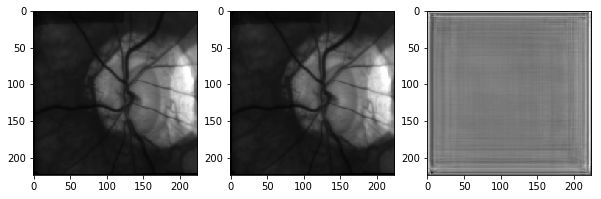

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(test_img)
plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.subplot(133)
plt.imshow(np.squeeze(preds), cmap='gray')

In [52]:
from skimage import data, color
from skimage import measure
from scipy.signal import medfilt2d

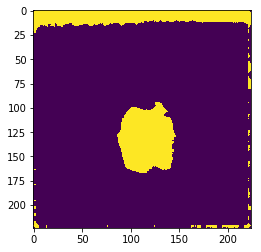

In [53]:
test_img_filtered = medfilt2d(prediction.astype(np.uint8), 5)
plt.imshow(test_img_filtered)

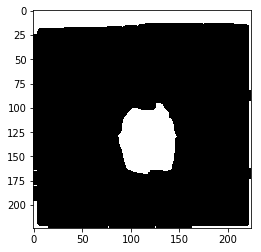

In [54]:
kernel = np.ones((12,12),np.uint8)
closing = cv2.morphologyEx(test_img_filtered, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

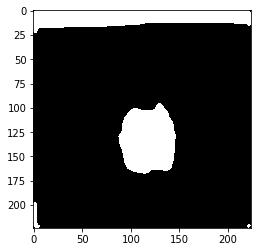

In [55]:
opening = medfilt2d(closing.astype(np.uint8), 5)
plt.imshow(opening, cmap='gray')

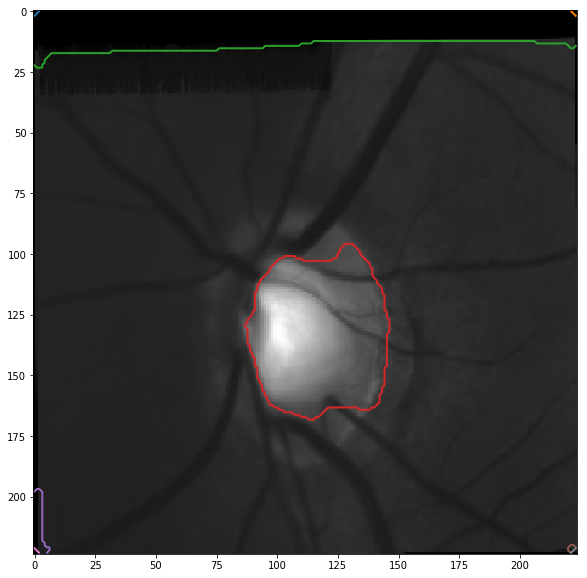

In [56]:
contours = measure.find_contours(opening, 0.8)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(test_img, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)